In [13]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
matplotlib.rcParams['figure.dpi'] = 150
import copy
from scipy.spatial import Delaunay
from collections import defaultdict
import random
import elkai
from functools import partial
import time
import ray
import psutil
from scipy import optimize
from scipy import interpolate
import pyecharts.options as opts
from pyecharts.charts import Scatter3D
import open3d as o3d

### Function

In [15]:
# functions

# calculate specks of circle
# input: rmax, maximum radius; rmin, minimum radius; area, maximum area of each speck
# output: s_set, a list of the area of specks; p_set, a list of the center of each speck
def circle_di(rmax, rmin, area, show = False):
    a = area**0.5
    nr = np.floor((rmax-rmin)/a)
    r = np.arange(rmin,rmax + (rmax-rmin)/(nr+1),(rmax-rmin)/nr)
    if show:
        for tr in r:
            tn = 100
            angle = np.arange(0,2*np.pi+2*np.pi/(tn+1),2*np.pi/tn)
            x = tr*np.cos(angle)
            y = tr*np.sin(angle)
            plt.plot(x,y,'b')

    theta_set = []
    s_set = []
    p_set = []
    for i in range(r.shape[0]-1):
        tr1 = r[i]
        tr2 = r[i+1]
        ts = np.pi*(tr2**2-tr1**2)
        tn = np.ceil(ts/area)
        theta = np.arange(0,2*np.pi+2*np.pi/(tn+1),2*np.pi/tn)
        if show:
            for ttheta in theta:
                plt.plot([tr1*np.cos(ttheta), tr2*np.cos(ttheta)],[tr1*np.sin(ttheta), tr2*np.sin(ttheta)],'b')
        for j in range(len(theta)-1):
            ttheta = (theta[j]+theta[j+1])/2
            tr = (tr1+tr2)/2
            p_set.append([tr*np.cos(ttheta),tr*np.sin(ttheta)])
            if show:
                plt.scatter(p_set[-1][0],p_set[-1][1],s = 1,color = 'r')
        theta_set.append(theta)
        s_set.extend([ts*(theta[1]-theta[0])/2/np.pi]*(len(theta)-1))
    return s_set, p_set

# calculate the connected points and triangles
# input: tri, nx3 index
# output: dic_tri_connected, dic_point_connected, dictionary whose values are indices of connected elements
def cal_connection(tri):
    dic_point_connected = {}
    dic_tri_connected = {}
    for i in range(tri.shape[0]):
        ttri = tri[i,:]
        edge = [[ttri[0],ttri[1]],[ttri[0],ttri[2]],[ttri[1],ttri[2]]]
        for j in range(3):
            a = edge[j][0]
            b = edge[j][1]
            if a not in dic_point_connected:
                dic_point_connected[a] = [b]
            else:
                if b not in dic_point_connected[a]:
                    dic_point_connected[a].append(b)
            if b not in dic_point_connected:
                dic_point_connected[b] = [a]
            else:
                if a not in dic_point_connected[b]:
                    dic_point_connected[b].append(a)
        if dic_tri_connected == {}:
            dic_tri_connected[0] = []
        else:
            for j in range(3):
                a = ttri[j]
                row = np.where(tri[:i,:] == a)[0]
                if row.shape[0] > 0 :
                    for tr in row:
                        if i not in dic_tri_connected[tr]:
                            dic_tri_connected[tr].append(i)
                        if i not in dic_tri_connected:
                            dic_tri_connected[i] = [tr]
                        else:
                            if tr not in dic_tri_connected[i]:
                                dic_tri_connected[i].append(tr)
    return dic_tri_connected, dic_point_connected

# whether a point p is in the triangle
# input: p, nx1; triangle, [p1,p2,p3]
# output: True or False
def if_in_tri(triangle,p):
    # nx1 array
    p1,p2,p3 = triangle
    s1 = np.cross(p1-p,p2-p1)
    s2 = np.cross(p2-p,p3-p2)
    s3 = np.cross(p3-p,p1-p3)
    if s1 >=0 and s2 >= 0 and s3>=0:
        return True
    elif s1 <=0 and s2 <= 0 and s3<=0:
        return True
    else:
        return False
#     if np.sign(np.cross(p2-p1,p-p1))*np.sign(np.cross(p2-p1,p3-p1)) >= 0:
#         if np.sign(np.cross(p3-p2,p-p2))*np.sign(np.cross(p3-p2,p1-p2)) >= 0:
#             if np.sign(np.cross(p1-p3,p-p3))*np.sign(np.cross(p1-p3,p2-p3)) >= 0:
#                 return True
    return False

def if_in_quad(quad, p):
    [p1,p2,p3,p4] = quad
    s1 = np.cross(p1-p,p2-p1)
    s2 = np.cross(p2-p,p3-p2)
    s3 = np.cross(p3-p,p4-p3)
    s4 = np.cross(p4-p,p1-p4)
    if s1 >=0 and s2 >= 0 and s3>=0 and s4 >=0:
        return True
    elif s1 <=0 and s2 <= 0 and s3<=0 and s4 <=0:
        return True
    else:
        return False


# calculate the depth from each point of disk to workpiece in the disk frame
# input: p_set, 3xn coordinates of disk points; AllPoints_array_CorInDisk, 3xn workpiece points; tri, nx3 index;dic_point_connected, index dic;
#        dic_tri_connected, index dic; radius_plane_estimate, radius to fit the plane
# output: h, a list of depths
def cal_depth(p_set, AllPoints_array_CorInDisk, radius_plane_estimate, show_procedure = False):
    inf = 100000
    h = []
    radius_for_depth = (np.max(p_set) - np.min(p_set))/2 + radius_plane_estimate
    workpiece_index = []
    r_set = []

    tr_set = np.linalg.norm(AllPoints_array_CorInDisk[:2,:],axis = 0)
    workpiece_index = list(np.where(tr_set < radius_for_depth)[0])
    NewPoints = AllPoints_array_CorInDisk[:,workpiece_index]
    r_set = tr_set[workpiece_index]

    for i in range(p_set.shape[1]):
        p = p_set[:2,i]
        tr_dicretep_set = np.linalg.norm(NewPoints[:2,:] - p.reshape(2,1),axis = 0)
        fit_index = np.where(tr_dicretep_set < radius_plane_estimate)[0]
        plane_p_set = NewPoints[:2, fit_index]
        z_set = NewPoints[2,fit_index]
        
        if plane_p_set.shape[1] >= 3:
            angle = []
            for j in range(plane_p_set.shape[1]):
                tp = plane_p_set[:,j]
                angle.append(np.arctan2(tp[1]-p[1],tp[0]-p[0]))
            angle = np.sort(angle)
            
            flag_in = True
            if angle[-1] - angle[0] < np.pi:
                flag_in = False
            else:
                for j in range(angle.shape[0]-1):
                    if angle[j+1]-angle[j] >np.pi:
                        flag_in = False
                        break
            if flag_in:
                plane_p_set = np.hstack((plane_p_set.T,np.ones(shape=(plane_p_set.shape[1],1))))
                z_set = z_set.reshape(z_set.shape[0],1)
                z_plane = np.asarray([0])
                P = plane_p_set.T.dot(plane_p_set)
                c = np.linalg.inv(P).dot(plane_p_set.T).dot(z_set)    
                z_plane = np.asarray([p[0],p[1],1]).dot(c)
                h.append(z_plane[0])
            else:
                h.append(-inf)
        else:
            h.append(-inf)
    return h, workpiece_index, r_set

# calculate the grinding force
# input: h, depth set, array; s, area set, array; E, MPa; H, m; Beta, coefficient
# output: normal force, N
def cal_force(h,s,E,H,Beta):
    return (E*((h>0)*h/H)**Beta).dot(s)

# calculate the grinding force
# input: F_desired, desired force, N; h, depth set, array; s, area set, array or list; E, MPa; H, m; Beta, coefficient
# output: d, mm
def cal_d_from_F(F_desired, h, s_set, E, H, Beta, d = 2, dd = 0.1, tolerance = 0.1, iteration_loop = 200):
    d = 2
    dd = 0.1
    tolerance = 0.1
    count = 0
    success = False
    while 1:
        f1 = cal_force(h+d,s_set,E,H,Beta) - F_desired
        f2 = cal_force(h+d+dd,s_set,E,H,Beta) - F_desired
        if abs(f2 - f1) < 10**(-8):
            return 0, False
        d = d - f1/(f2-f1)*dd
        count += 1
        if abs(f1) < tolerance:
            success = True
            break
        elif count > iteration_loop:
            success = False
            break
    return d, success

# calculate the rotation matrix through eular angles. order, xyz
# input: pitch, x axis; yaw, y axis; roll, z
# output: rotation matrix
def R_from_angles(pitch, yaw, roll):
    Rx = np.asarray([[1,0,0],[0, np.cos(pitch), - np.sin(pitch)], [0, np.sin(pitch), np.cos(pitch)]])
    Ry = np.asarray([[np.cos(yaw),0,np.sin(yaw)],[0,1,0],[-np.sin(yaw),0,np.cos(yaw)]])
    Rz = np.asarray([[np.cos(roll), -np.sin(roll),0],[np.sin(roll), np.cos(roll),0],[0,0,1]])
    return Rz.dot(Ry).dot(Rx)

# calculate the rotaion matrix representing the frame whose z axis is normal of workpiece point
# input: fd, feed direction (x axis), (2,) array, (x,y); normal, normal direction, (3,)
# output: rotation matrix
def R_from_fd_and_normal(fd, normal):
    x,y = fd
    a = normal[0]*x +normal[1]*y
    b = normal[2]
    if a != 0 and b != 0:
        k = -b/a
        z = 1
        if k < 0 :
            k = -k
            z = -1
    elif a ==0 and b != 0:
        k = 1
        z = 0
    elif a != 0 and b == 0:
        k = 0
        z = 1
    else:
        print('The surface is vertical. ')
        return None
    x_axis = np.asarray([x*k,y*k,z])
    x_axis = x_axis/np.linalg.norm(x_axis)
    y_axis = np.cross(normal,x_axis)
    Rt = np.asarray([x_axis,y_axis,normal])
    return Rt.T
    

### Load the Model

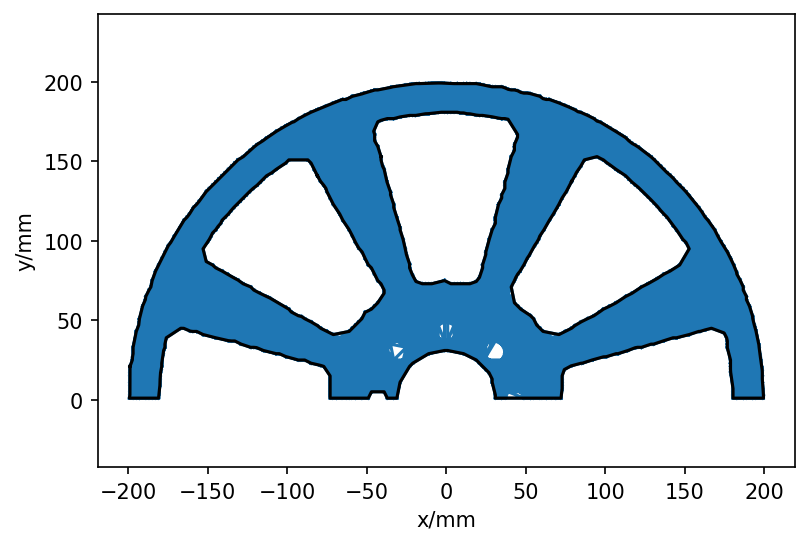

In [16]:
pcd = o3d.io.read_point_cloud("Model_Data/Wheel_upper_surface.ply")
pcd.normalize_normals()
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=50, origin=[0,0,0])

# #show in the open3d
# o3d.visualization.draw_geometries([pcd,mesh_frame],
#                                   zoom=0.3412,
#                                   front=[0.4257, -0.2125, -0.8795],
#                                   lookat=[2.6172, 2.0475, 1.532],
#                                   up=[-0.0694, -0.9768, 0.2024],
#                                   point_show_normal=True) 

points = np.asarray(pcd.points)
normals = np.asarray(pcd.normals)
new_tri_set = np.load('Model_Data/new_tri_set.npy')

# tri_set after alpha_shape
final_contour = np.load('Model_Data/final_contour.npy',allow_pickle= True)
final_contour = list(final_contour)
# point index set of a contour
points_yz = points[:,:2]

plt.triplot(points_yz[:,0],points_yz[:,1],new_tri_set)
final_contour_points = []
for i in range(len(final_contour)):
    x = [points_yz[j][0] for j in final_contour[i]]
    y = [points_yz[j][1] for j in final_contour[i]]
    final_contour_points.append([x,y])
    plt.plot(x,y,color = 'k')
plt.axis('equal')
plt.xlabel('x/mm')
plt.ylabel('y/mm')
plt.show()

bound_y = [np.min(points_yz[:,0]), np.max(points_yz[:,0])]
bound_z = [np.min(points_yz[:,1]), np.max(points_yz[:,1])]
center = np.asarray([0,0])
final_contour_points_polar = []
contour_bounds_polar = []
for i in range(len(final_contour)):
    r = [np.linalg.norm(points_yz[index,:] - center) for index in final_contour[i]]
    theta = [np.arctan2((points_yz[index,:] - center)[1],(points_yz[index,:] - center)[0]) for index in final_contour[i]]
    final_contour_points_polar.append([r,theta])
    contour_bounds_polar.append([np.min(r),np.max(r),np.min(theta),np.max(theta)])

ta = np.asarray(contour_bounds_polar)

points_yz_polar = []
for i in range(points_yz.shape[0]):
    r = np.linalg.norm(points_yz[i,:])
    theta = np.arctan2(points_yz[i,1],points_yz[i,0])
    points_yz_polar.append([r,theta])
points_yz_polar = np.asarray(points_yz_polar)

### Choose one subsurface

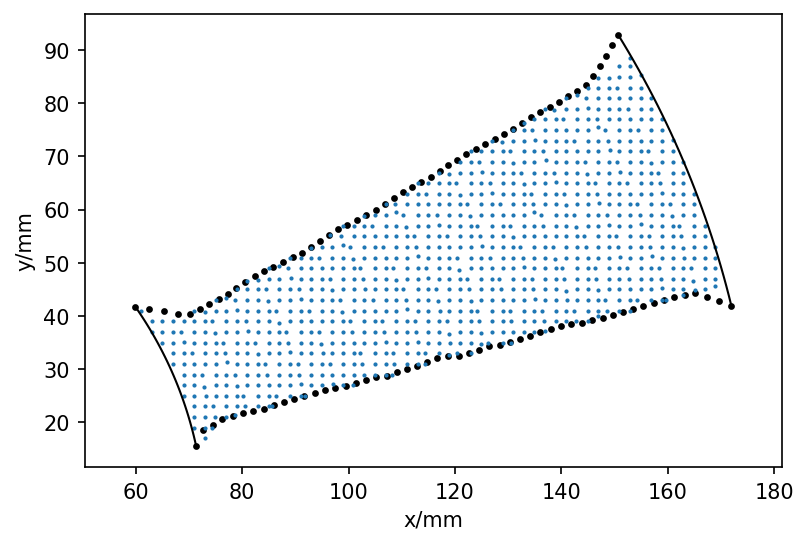

In [19]:
spoke_list = []
for i in range(6):
    spoke_list.append(np.load('Model_Data/spoke'+str(i)+'.npy')) # [[r,....],[theta1,...],[theta2,...]]
area_id = 1 # choose one subsurface
num_cpus = 3
spoke = spoke_list[area_id] # 73 177

bp1 = [spoke[0][0]*(np.cos(spoke[1][0])+np.cos(spoke[2][0]))/2,spoke[0][0]*(np.sin(spoke[1][0])+np.sin(spoke[2][0]))/2]
bp2 = [spoke[0][-1]*(np.cos(spoke[1][-1])+np.cos(spoke[2][-1]))/2,spoke[0][-1]*(np.sin(spoke[1][-1])+np.sin(spoke[2][-1]))/2]

n = 30
y1 = [spoke[0][index]*np.cos(spoke[1][index]) for index in range(len(spoke[0]))]
z1 = [spoke[0][index]*np.sin(spoke[1][index]) for index in range(len(spoke[0]))]
y2 = [spoke[0][index]*np.cos(spoke[2][index]) for index in range(len(spoke[0]))]
z2 = [spoke[0][index]*np.sin(spoke[2][index]) for index in range(len(spoke[0]))]
plt.scatter(y1+y2,z1+z2,s = 5, color = 'k')
r1 = spoke[0][0]
r2 = spoke[0][-1]
theta1i = spoke[1][0]
theta1a = spoke[2][0]
theta2i = spoke[1][-1]
theta2a = spoke[2][-1]
if theta1a < theta1i:
    theta1a += np.pi*2
if theta2a < theta2i:
    theta2a += np.pi*2
angle1 = np.linspace(theta1i, theta1a, n)
angle2 = np.linspace(theta2i, theta2a, n)
arc1 = [r1*np.cos(angle1),r1*np.sin(angle1)]
arc2 = [r2*np.cos(angle2),r2*np.sin(angle2)]
plt.plot(arc1[0], arc1[1], color = 'k', linewidth = 1)
plt.plot(arc2[0], arc2[1], color = 'k', linewidth = 1)
plt.xlabel('x/mm')
plt.ylabel('y/mm')
plt.axis('equal')

points_spoke = []
points_spoke_polar = []
remain_index = []
for i in range(points_yz_polar.shape[0]):
    if points_yz_polar[i,0] < spoke[0][-1] and points_yz_polar[i,0]>=spoke[0][0]:
        for j in range(len(spoke[0])):
            if points_yz_polar[i,0]>= spoke[0][j]:
                continue
            else:
                if points_yz_polar[i,1] <= np.max([spoke[2][j],spoke[2][j-1]]) and points_yz_polar[i,1] >= np.min([spoke[1][j],spoke[1][j-1]]):
                    points_spoke.append(points_yz[i,:])
                    points_spoke_polar.append(points_yz_polar[i,:])
                    remain_index.append(i)
                    break
points_spoke = np.asarray(points_spoke)
plt.scatter(points_spoke[:,0],points_spoke[:,1],s = 1)
plt.axis('equal')
plt.show()

pcd_spoke = pcd.select_by_index(remain_index)
grey = [190/255,190/255,190/255]
black = [0,0,0]
white = [1,1,1]
yellow = [1,1,0]
red = [1,0,0]
blue = [0,0,1]

pcd_spoke.paint_uniform_color(red)  
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=20, origin=[0,0,0])

# # show and save
# o3d.visualization.draw_geometries([pcd_spoke,mesh_frame],
#                                   zoom=1,
#                                   front=[0,0.6,0.8],
#                                   lookat=[100, 50, 1.532],
#                                   up=[-0.0694, -0.9768, 0.2024],
#                                   point_show_normal=False)
# o3d.io.write_point_cloud('spoke1.ply',pcd_remain)

AllPoints = np.asarray(pcd_spoke.points)
AllNormals = np.asarray(pcd_spoke.normals)

### Physical parameters

In [24]:
# parameters 
E = 0.84  # modulus /MPa
Beta = 0.89 # power index
H = 10  # mm disc thickness 
K = 0.0453  # 0.0000136*1000 μm material removal coefficient 
disk_R = 37.5 # mm %tool radius /m
Tilt_angle = 12*np.pi/180
Omega = 2*np.pi*5000/60 # 3000r /min
feedrate = 50 # feedrate=50; % mm/s

### Model the environment

In [26]:

def fun_plane(x,y):
    r = (x**2+y**2)**0.5
    if r < 55 :
        z = 60
    else:
        z = 60+550/29-10/29*r
    return z

def fun_plane_normal(x,y):
    r = (x**2+y**2)**0.5
    if r < 55:
        tv = np.asarray([0,0,1])
    else:
        tv = np.asarray([50,0,145])
    theta = np.arctan2(y,x)
    R = R_from_angles(0,0, theta)
    v = R.dot(tv.reshape(3,1)).reshape(3)
    v = v/np.linalg.norm(v)
    return v

workpiece_pcd = o3d.geometry.PointCloud()  
AllPoints_array = np.asarray(AllPoints)
AllNormals_array = np.asarray(AllNormals)
color = np.asarray([[0],[0],[0]])

workpiece_pcd.points = o3d.utility.Vector3dVector(AllPoints_array)
workpiece_pcd.normals = o3d.utility.Vector3dVector(AllNormals_array)
workpiece_pcd.paint_uniform_color(color)  

# triangle mesh for the plane. using 3d alphashape
radii = [1,2,4,8]
rec_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    workpiece_pcd, o3d.utility.DoubleVector(radii))
tri = np.asarray(rec_mesh.triangles)

# disk
area = 4
rmax = disk_R
rmin = 1   
s_set, p_set = circle_di(rmax, rmin, area, show = False)
s_set = np.asarray(s_set)
p_set = np.asarray(p_set).T
p_set = np.vstack((p_set,np.zeros(shape=(1,p_set.shape[1]))))
# array, 3xn

radius_plane_estimate = 5
pitch = 0
yaw = - Tilt_angle
roll = 0
angles = [pitch,yaw,roll]

dt = 1

F_desired = 8

ModelParameter = [E, H, Beta, K,Omega]


def fun_reward(x,y,c):
    r = c[0]*x*x + c[1]*y*y + c[2]*x*y + c[3]*x + c[4]*y + c[5]
    return r
reward_array = np.zeros(shape = (AllPoints_array.shape[0] , 1))
c_surface = [0,0,0,0,0,1]
for i in range(AllPoints_array.shape[0]):
    reward_array[i,0] = fun_reward(AllPoints_array[i,0],AllPoints_array[i,1],c_surface)
if np.max(reward_array)-np.min(reward_array) != 0:
    reward_array = (reward_array-np.min(reward_array))/(np.max(reward_array)-np.min(reward_array))
else:
    reward_array = reward_array/np.max(reward_array)
reward_array = reward_array/2 + 0.5
initial_reward_array = copy.deepcopy(reward_array)

### Grinding simulation function

In [27]:
# function to grind at a fixed point
@ray.remote(num_returns=3)
def grinding_point(p_contacted, angles, R, F_desired, dt, p_set, AllPoints_array, radius_plane_estimate, ModelParameter):
    E, H, Beta, K,Omega = ModelParameter
    pitch, yaw, roll = angles
    R_disk = R.dot(R_from_angles(pitch,yaw,roll))
    p_disk = R_disk.dot(np.asarray([[rmax],[0],[0]]))+p_contacted
    # rotate the disk
    p_set_CorInPlane = R_disk.dot(p_set) + p_disk

    # workpiece coordinates in the disk frame
    AllPoints_array_CorInDisk = R_disk.T.dot(AllPoints_array.T)-R_disk.T.dot(p_disk)
    h, workpiece_index, r_set = cal_depth(p_set, AllPoints_array_CorInDisk, radius_plane_estimate)
    h = np.asarray(h)
    d, _ = cal_d_from_F(F_desired, h, s_set, E, H, Beta, d = 2, dd = 0.1, tolerance = 0.1, iteration_loop = 200)
    # reward means grinding depth. scale is the ratio between grinding depth and reward.
    new_f_workpiece_index = []
    removal = []
    for i in range(len(workpiece_index)):
        if r_set[i] < disk_R:
            th = AllPoints_array_CorInDisk[2,workpiece_index[i]]
            th += d
            tr = r_set[i]
            if th > 0:
                pressure = E*(th/H)**Beta
                slide_speed=Omega*tr
                removal.append(K*pressure*slide_speed*dt)
                new_f_workpiece_index.append(workpiece_index[i])
    return new_f_workpiece_index, removal,d     

# generate the discrete path points
def gen_path_point(r,boundary,step):
    if r < boundary[0,0]:
        print('r is too small.out of boundary.')
    if r > boundary[0,-1]:
        print('r is too big.out of boundary.')
    for i in range(1, boundary.shape[1]-1):
        if r < boundary[0,i]:
            break
    theta1 = boundary[1,i-1] + (r - boundary[0,i-1])/(boundary[0,i]-boundary[0,i-1])*(boundary[1,i]-boundary[1,i-1])
    theta2 = boundary[2,i-1] + (r - boundary[0,i-1])/(boundary[0,i]-boundary[0,i-1])*(boundary[2,i]-boundary[2,i-1])
    angle_step = step/r
    theta = theta1
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    z = fun_plane(x,y)
    path_point = []
    pre_p = np.asarray([[x],[y],[z]])
    path_point.append(pre_p)
    alpha = 0.9
    tol = 0.001
    while 1:
        tangle_step = angle_step
        while 1:
            ttheta = theta + tangle_step
            x = r*np.cos(ttheta)
            y = r*np.sin(ttheta)
            z = fun_plane(x,y)
            tp = np.asarray([[x],[y],[fun_plane(x,y)]])
            tl = np.linalg.norm(tp - pre_p)
            if abs(tl - step) < tol:
                theta = ttheta
                path_point.append(tp)
                pre_p = tp
                break
            elif tl > step:
                tangle_step *= alpha
            elif tl < step:
                theta = ttheta
        if theta > theta2:
            break
    if len(path_point) < 12:
        print('the path is too short')
        return None
    return path_point[:-5]

# function to grind along a curve 
def grind_curve(path_point, step = 2, vmax = 2, amax = 2):

    p_contacted_set = []
    fd_set = []
    for i in range(len(path_point)-1):
        p_contacted_set.append((path_point[i]+path_point[i+1])/2)
        tfd = (path_point[i+1]-path_point[i])[:2,0]
        fd_set.append(tfd/np.linalg.norm(tfd))

    R_set = []
    for i in range(len(p_contacted_set)):
        z_axis = fun_plane_normal(p_contacted_set[i][0,0],p_contacted_set[i][1,0])
        R = R_from_fd_and_normal(fd_set[i],z_axis)
        R_set.append(R)

    dt = 1
    f_workpiece_index_ids = []
    removal_ids = []
    d_ids = []

    for i in range(len(p_contacted_set)):
        ids = grinding_point.remote(p_contacted_set[i], angles, R_set[i], F_desired, dt, p_set_id, AllPoints_array_id, radius_plane_estimate, 
                                    ModelParameter_id)
        f_workpiece_index_ids.append(ids[0])
        removal_ids.append(ids[1])
        d_ids.append(ids[2])

    f_workpiece_index = ray.get(f_workpiece_index_ids)
    removal = ray.get(removal_ids)
    d = ray.get(d_ids)
    
    empty_index = []
    for i in range(len(f_workpiece_index)):
        if len(f_workpiece_index[i]) == 0:
            empty_index.append(i)
    for i in range(len(empty_index)):
        pop_index = empty_index[-1-i]
        f_workpiece_index.pop(pop_index)
        removal.pop(pop_index)
        d.pop(pop_index)

#     c = []
#     for i in range(len(removal)):
#         c.append(np.sum(removal[i]))
#     c = np.asarray(c)

    c = []
    for i in range(len(removal)):
        tr = 0
        for j in range(len(removal[i])):
            tr += removal[i][j]
#             tr += removal[i][j]*vertex_area_set[f_workpiece_index[i][j]]
        c.append(tr)
    c = np.asarray(c)
#     print(np.max(c), np.mean(c))
    c = c/amplifier
    

    all_removed_index = []
    for i in range(len(f_workpiece_index)):
        for index in f_workpiece_index[i]:
            if index not in all_removed_index:
                all_removed_index.append(index)

    c_st1 = []
    for index in all_removed_index:
        c_row = []
        for i in range(len(f_workpiece_index)):
            j = np.where(np.asarray(f_workpiece_index[i]) == index)[0]
            if j.shape[0] != 0:
                j = j[0]
                c_row.append(removal[i][j])
            else:
                c_row.append(0)
        c_st1.append(c_row)
    c_st1 = np.asarray(c_st1)

    c_st1_right = []
    for index in all_removed_index:
        c_st1_right.append(reward_array[index,0])
    c_st1_right = np.asarray(c_st1_right)

    tn = c.shape[0]
    def opt_cost_fun(x):
        return -c.dot(x)

    def opt_jac(x):
        return -c
    def opt_hes(x):
        return np.zeros(shape = (tn,tn))

    def opt_nonlinear_con(x):
#         temp = []
#         for i in range(tn-1):
#             temp.append(2*step*(x[i+1]-x[i])/(x[i+1]+x[i])/x[i]/x[i+1])
        temp = []
        temp.append((-x[1]+x[0])/x[0]**3*step)
        for i in range(tn-2):
            temp.append((-x[i+2]+x[i])/x[i+1]**3*step/2)
        temp.append((-x[-1]+x[-2])/x[-1]**3*step)
        temp = np.asarray(temp)
        return temp
    
    
#     res = optimize.linprog(-c,c_st1,c_st1_right,bounds=[(step/vmax,None)]*tn)

#     x0 = np.ones(tn)*(step/vmax+0.1)
#     res = optimize.minimize(opt_cost_fun, x0, jac = opt_jac, bounds=optimize.Bounds(lb=np.ones(tn)*step/vmax,ub=np.inf),
#                             constraints=[optimize.LinearConstraint(A = c_st1, lb=-np.inf,ub=c_st1_right)])

#     x0 = np.ones(tn)*(step/vmax+0.1)
#     res = optimize.minimize(opt_cost_fun, x0, jac = opt_jac, hess = opt_hes, method = 'COBYLA', bounds=optimize.Bounds(lb=np.ones(tn)*step/vmax,ub=np.inf),
#                             constraints=[optimize.LinearConstraint(A = c_st1, lb=-np.inf,ub=c_st1_right), optimize.NonlinearConstraint(fun=opt_nonlinear_con,
#                                                                                                                             lb=-np.ones(tn-1)*amax, ub=np.ones(tn-1)*amax)])
    
    x0 = np.ones(tn)*(step/vmax+0.2)
    res = optimize.minimize(opt_cost_fun, x0, jac = opt_jac,bounds=optimize.Bounds(lb=np.ones(tn)*step/vmax,ub=np.inf),
                            constraints=[optimize.LinearConstraint(A = c_st1, lb=-np.inf,ub=c_st1_right), optimize.NonlinearConstraint(fun=opt_nonlinear_con,
                                                                                                                            lb=-np.ones(tn-1)*amax, ub=np.ones(tn-1)*amax)])

    flag = 0

    if not res.success:
        flag = 1
        print(res.message,res.status)
        
    return res, f_workpiece_index, removal, empty_index, flag


# function to determine the space between current curve and next curve
def next_curve(r1,r0):
    path_point_new = gen_path_point(r1, spoke, step)
    res, f_workpiece_index, removal, empty_index, flag = grind_curve(path_point_new, step = step, vmax = vmax, amax = amax)
    for i in range(len(empty_index)):
        pop_index = empty_index[-1-i]
        path_point_new.pop(pop_index+1)
    
    if flag == 1:
        return None, None, None, None, None, flag
    reward_array_temp = copy.deepcopy(reward_array)
    
    for i in range(len(f_workpiece_index)):
        for j in range(len(f_workpiece_index[i])):
            reward_array_temp[f_workpiece_index[i][j], 0] -= removal[i][j]*res.x[i]
    interval_reward_volumn = []
    for i in range(AllPoints_array.shape[0]):
        p_temp = AllPoints_array[i,:2]
        if np.linalg.norm(p_temp) < r1 and np.linalg.norm(p_temp) > r0:
#         if if_in_quad(quad, p_temp):
            interval_reward_volumn.append(reward_array_temp[i,0])
#             interval_reward_volumn.append(reward_array_temp[i,0]*vertex_area_set[i])
    interval_reward_volumn = np.asarray(interval_reward_volumn)
    if res.success == False:
        print(res)
    return -res.fun, np.mean(interval_reward_volumn), reward_array_temp, res.x, path_point_new, flag


### Initialize

In [ ]:
ray.init(num_cpus = num_cpus, ignore_reinit_error=True)
AllPoints_array_id = ray.put(AllPoints_array)
ModelParameter_id = ray.put(ModelParameter)
p_set_id = ray.put(p_set)

### Grinding the first curve

In [70]:
r_min = np.min(spoke[0,:])+21
r_max = np.max(spoke[0,:])-21
r = r_min
r_set = [r]
step = 1
amplifier = 100
path_point = gen_path_point(r_set[0], spoke, step)
path_point_set = []
# path_point = np.asarray(path_point)
# plt.scatter(y1+y2,z1+z2,s = 5, color = 'k')
# plt.plot(arc1[0], arc1[1], color = 'k', linewidth = 1)
# plt.plot(arc2[0], arc2[1], color = 'k', linewidth = 1)
# plt.xlabel('x/mm')
# plt.ylabel('y/mm')
# plt.scatter(path_point[:,0,0],path_point[:,1,0])
reward_array = copy.deepcopy(initial_reward_array)
scale = 30
reward_array = reward_array*scale

amax = 10
vmax = 50 # should be big enough
ps = time.time()
res, f_workpiece_index, removal, empty_index, flag = grind_curve(path_point, step = step, vmax = vmax, amax = amax)
for i in range(len(f_workpiece_index)):
    for j in range(len(f_workpiece_index[i])):
        reward_array[f_workpiece_index[i][j], 0] -= removal[i][j]*res.x[i]
        
for i in range(len(empty_index)):
    pop_index = empty_index[-1-i]
    path_point.pop(pop_index+1)
path_point_set.append(path_point)
print(time.time()-ps)
print(res.fun)

0.43885374069213867
-31.827059735349795


### Visualization

In [50]:
colors = []
for i in range(AllNormals_array.shape[0]):
    colors.append((1-reward_array[i,0]/scale)*np.asarray(yellow)+reward_array[i,0]/scale*np.asarray(red))
       
pcd_spoke.colors = o3d.utility.Vector3dVector(np.asarray(colors))


mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=20, origin=[0,0,0])


o3d.visualization.draw_geometries([pcd_spoke,mesh_frame],
                                  zoom=1,
                                  front=[0,0.6,0.8],
                                  lookat=[100, 50, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024],
                                  point_show_normal=False)

In [41]:
import pyecharts.options as opts
from pyecharts.charts import Scatter3D


# 配置 config
config_xAxis3D = "x"
config_yAxis3D = "y"
config_zAxis3D = "reward"

# 构造数据
data = [[AllPoints_array[i,0], AllPoints_array[i,1], reward_array[i,0]] for i in range(reward_array.shape[0])]

(
    Scatter3D(
        init_opts=opts.InitOpts(width="1440px", height="720px")
    )  # bg_color="black"
    .add(
        series_name="",
        data=data,
        xaxis3d_opts=opts.Axis3DOpts(
            name=config_xAxis3D,
            type_="value",
            min_ = 50,
            max_ = 180
            # textstyle_opts=opts.TextStyleOpts(color="#fff"),
        ),
        yaxis3d_opts=opts.Axis3DOpts(
            name=config_yAxis3D,
            type_="value",
            min_ = -30,
            max_ = 100
            # textstyle_opts=opts.TextStyleOpts(color="#fff"),
        ),
        zaxis3d_opts=opts.Axis3DOpts(
            name=config_zAxis3D,
            type_="value",
            min_ = 0,
            max_ = 30
            # textstyle_opts=opts.TextStyleOpts(color="#fff"),
        ),
        grid3d_opts=opts.Grid3DOpts(width=90, height=90, depth=90),
    )
    .set_global_opts(
        visualmap_opts=[
            opts.VisualMapOpts(
                type_="color",
                is_calculable=True,
                dimension=2,
                pos_top="150",
                pos_left="330",
                max_=20,
                range_color=[
                    "#1710c0",
                    "#0b9df0",
                    "#00fea8",
                    "#00ff0d",
                    "#f5f811",
                    "#f09a09",
                    "#fe0300",
                ],
            )
        ]
    )
    .render_notebook()
)

### Path plan through greedy algorithm

In [62]:
ts_set = []
ts_set.append(copy.deepcopy(res.x))
total_removal_set = [-res.fun*amplifier]
removal_mean_set = []

alpha = 0.5
weight = 1
tol = 1
cr = r_set[0]
count = 0
while 1:
    print(cr)
    r_step = 4
    r = cr + 20
    Terminate = False
    while 1:
        print('find first', r)
        tr = r+r_step
        if tr > r_max:
            tr = r_max
        total_removal, interval_mean, reward_array_temp, ts, path_point_new, flag = next_curve(tr,cr)   
        if flag == 1:
            if tr != r_max:
                r = tr
                continue
            else:
                Terminate = True
                break
        else:
            break
    if Terminate:
        break
    
    r = tr
    value0 = weight* interval_mean
    total_removal_set.append(total_removal*amplifier)
    removal_mean_set.append(interval_mean)
    path_point_set.append(path_point_new)
    
    tts = copy.deepcopy(ts)
    t_reward = copy.deepcopy(reward_array_temp)
    
    subTerminate = False
    ever_s1 = False
    ever_s2 = True
    print('initial r y:', r, value0)
    while 1:
        print('r y:', r, value0)
        ever_s1 = False
        while 1:
            print('+:',r,r_step)
            tr = r+r_step
            if tr > r_max:
                tr = r_max
            total_removal, interval_mean, reward_array_temp, ts, path_point_new, flag = next_curve(tr,cr)   
            if flag == 0:
                value =  weight* interval_mean
                if value < value0:
                    value0 = value
                    tts = copy.deepcopy(ts)
                    t_reward = copy.deepcopy(reward_array_temp)
                    total_removal_set[-1] = total_removal*amplifier
                    removal_mean_set[-1] = interval_mean
                    path_point_set[-1] = path_point_new
                    ever_s1 = True
                    r = tr
                    continue
            break
        if ever_s1 or (ever_s1 == False and ever_s2 == False):
            r_step = r_step*alpha
            if r_step < tol:
                subTerminate = True
        if subTerminate:
            break

        ever_s2 = False
        while 1:
            print('-:',r,r_step)
            tr = r-r_step
            if tr < cr:
                tr = cr
            total_removal, interval_mean, reward_array_temp, ts, path_point_new, flag = next_curve(tr,cr)   
            if flag == 0:
                value =  weight* interval_mean
                if value < value0:
                    value0 = value
                    tts = copy.deepcopy(ts)
                    t_reward = copy.deepcopy(reward_array_temp)
                    total_removal_set[-1] = total_removal*amplifier
                    removal_mean_set[-1] = interval_mean
                    path_point_set[-1] = path_point_new
                    ever_s2 = True
                    r = tr
                    continue
            break
        if ever_s2 or (ever_s1 == False and ever_s2 == False):
            r_step = r_step*alpha
            if r_step < tol:
                subTerminate = True
        if subTerminate:
            break
    if r == cr :
        Terminate = True
    if Terminate:
        break
    cr = r
    ts_set.append(copy.deepcopy(tts))
    r_set.append(r)
    reward_array = t_reward
    count += 1
    if count == 3:
        break

93.99323281237469
find first 113.99323281237469
initial r y: 117.99323281237469 9.28836460839379
r y: 117.99323281237469 9.28836460839379
+: 117.99323281237469 4
-: 117.99323281237469 4
Positive directional derivative for linesearch 8
r y: 117.99323281237469 9.28836460839379
+: 117.99323281237469 2.0
-: 117.99323281237469 1.0
-: 116.99323281237469 1.0
-: 115.99323281237469 1.0
Positive directional derivative for linesearch 8
115.99323281237469
find first 135.99323281237469
initial r y: 139.99323281237469 8.357108533446922
r y: 139.99323281237469 8.357108533446922
+: 139.99323281237469 4
-: 139.99323281237469 4
Positive directional derivative for linesearch 8
r y: 139.99323281237469 8.357108533446922
+: 139.99323281237469 2.0
-: 139.99323281237469 1.0
-: 138.99323281237469 1.0
-: 137.99323281237469 1.0
Inequality constraints incompatible 4
137.99323281237469
find first 157.99323281237469
Positive directional derivative for linesearch 8


In [64]:
# #save

# np.save('ex3_1_reward_array_spoke'+str(area_id)+'greedy',reward_array) # 1: a=5 v=15, r=30; 2: a = 1 v = 40 r = 20
# np.save('ex3_1_r_set_spoke'+str(area_id)+'greedy',r_set)
# np.save('ex3_1_ts_set_spoke'+str(area_id)+'greedy',ts_set)
# np.save('ex3_1_pathpoint_set_spoke'+str(area_id)+'greedy',path_point_set)


### Visualization

In [219]:

config_xAxis3D = "x"
config_yAxis3D = "y"
config_zAxis3D = "reward"

# 构造数据
data = [[AllPoints_array[i,0], AllPoints_array[i,1], reward_array[i,0]] for i in range(reward_array.shape[0])]

(
    Scatter3D(
        init_opts=opts.InitOpts(width="1440px", height="720px")
    )  # bg_color="black"
    .add(
        series_name="",
        data=data,
        xaxis3d_opts=opts.Axis3DOpts(
            name=config_xAxis3D,
            type_="value",
            min_ = -120,
            max_ = 10
            # textstyle_opts=opts.TextStyleOpts(color="#fff"),
        ),
        yaxis3d_opts=opts.Axis3DOpts(
            name=config_yAxis3D,
            type_="value",
            min_ = 50,
            max_ = 180
            # textstyle_opts=opts.TextStyleOpts(color="#fff"),
        ),
        zaxis3d_opts=opts.Axis3DOpts(
            name=config_zAxis3D,
            type_="value",
            min_ = 0,
            max_ = 30
            # textstyle_opts=opts.TextStyleOpts(color="#fff"),
        ),
        grid3d_opts=opts.Grid3DOpts(width=90, height=90, depth=90),
    )
    .set_global_opts(
        visualmap_opts=[
            opts.VisualMapOpts(
                type_="color",
                is_calculable=True,
                dimension=2,
                pos_top="150",
                pos_left="330",
                max_=20,
                range_color=[
                    "#1710c0",
                    "#0b9df0",
                    "#00fea8",
                    "#00ff0d",
                    "#f5f811",
                    "#f09a09",
                    "#fe0300",
                ],
            )
        ]
    )
    .render_notebook()
)

In [221]:
interval_reward_volumn = []
for i in range(AllPoints_array.shape[0]):
    p_temp = AllPoints_array[i,:2]
    if np.linalg.norm(p_temp) < np.max(r_set) and np.linalg.norm(p_temp) > np.min(r_set):
#         if if_in_quad(quad, p_temp):
        interval_reward_volumn.append(reward_array[i,0])
#             interval_reward_volumn.append(reward_array_temp[i,0]*vertex_area_set[i])
interval_reward_volumn = np.asarray(interval_reward_volumn)
print('residual depth: ',np.mean(interval_reward_volumn))


7.943214940814007

### Global Algorithm

In [23]:
# function. Global algorithm
def grind_curve2(path_point_set, step = 2, vmax = 2, amax = 2):
    f_p_contacted_set = []
    f_R_set = []
    
    for path_point in path_point_set:
        p_contacted_set = []
        fd_set = []
        for i in range(len(path_point)-1):
            p_contacted_set.append((path_point[i]+path_point[i+1])/2)
            tfd = (path_point[i+1]-path_point[i])[:2,0]
            fd_set.append(tfd/np.linalg.norm(tfd))

        R_set = []
        for i in range(len(p_contacted_set)):
            z_axis = fun_plane_normal(p_contacted_set[i][0,0],p_contacted_set[i][1,0])
            R = R_from_fd_and_normal(fd_set[i],z_axis)
            R_set.append(R)
        f_p_contacted_set.extend(p_contacted_set)
        f_R_set.extend(R_set)
    dt = 1
    f_workpiece_index_ids = []
    removal_ids = []
    d_ids = []

    for i in range(len(f_p_contacted_set)):
        ids = grinding_point.remote(f_p_contacted_set[i], angles, f_R_set[i], F_desired, dt, p_set_id, AllPoints_array_id, radius_plane_estimate, 
                                    ModelParameter_id)
        f_workpiece_index_ids.append(ids[0])
        removal_ids.append(ids[1])
        d_ids.append(ids[2])

    f_workpiece_index = ray.get(f_workpiece_index_ids)
    removal = ray.get(removal_ids)
    d = ray.get(d_ids)
    
    empty_index = []
    for i in range(len(f_workpiece_index)):
        if len(f_workpiece_index[i]) == 0:
            empty_index.append(i)
            
    for i in range(len(empty_index)):
        pop_index = empty_index[-1-i]
        f_workpiece_index.pop(pop_index)
        removal.pop(pop_index)
        d.pop(pop_index)
#     c = []
#     for i in range(len(removal)):
#         c.append(np.sum(removal[i]))
#     c = np.asarray(c)

    c = []
    for i in range(len(removal)):
        tr = 0
        for j in range(len(removal[i])):
            tr += removal[i][j]
#             tr += removal[i][j]*vertex_area_set[f_workpiece_index[i][j]]
        c.append(tr)
    c = np.asarray(c)
#     print(np.max(c), np.mean(c))
    c = c/amplifier
    

    all_removed_index = []
    for i in range(len(f_workpiece_index)):
        for index in f_workpiece_index[i]:
            if index not in all_removed_index:
                all_removed_index.append(index)

    c_st1 = []
    for index in all_removed_index:
        c_row = []
        for i in range(len(f_workpiece_index)):
            j = np.where(np.asarray(f_workpiece_index[i]) == index)[0]
            if j.shape[0] != 0:
                j = j[0]
                c_row.append(removal[i][j])
            else:
                c_row.append(0)
        c_st1.append(c_row)
    c_st1 = np.asarray(c_st1)

    c_st1_right = []
    for index in all_removed_index:
        c_st1_right.append(reward_array[index,0])
    c_st1_right = np.asarray(c_st1_right)

    tn = c.shape[0]
    def opt_cost_fun(x):
        return -c.dot(x)

    def opt_jac(x):
        return -c
    def opt_hes(x):
        return np.zeros(shape = (tn,tn))

    def opt_nonlinear_con(x):
        temp = []
        for i in range(tn-1):
            temp.append(2*step*(x[i+1]-x[i])/(x[i+1]+x[i])/x[i]/x[i+1])
        
#         temp = []
#         temp.append((-x[1]+x[0])/x[0]**3*step)
#         for i in range(tn-2):
#             temp.append((-x[i+2]+x[i])/x[i+1]**3*step/2)
#         temp.append((-x[-1]+x[-2])/x[-1]**3*step)
#         temp = np.asarray(temp)
        return temp
    
    
#     res = optimize.linprog(-c,c_st1,c_st1_right,bounds=[(step/vmax,None)]*tn)

#     x0 = np.ones(tn)*(step/vmax+0.1)
#     res = optimize.minimize(opt_cost_fun, x0, jac = opt_jac, bounds=optimize.Bounds(lb=np.ones(tn)*step/vmax,ub=np.inf),
#                             constraints=[optimize.LinearConstraint(A = c_st1, lb=-np.inf,ub=c_st1_right)])

    x0 = np.ones(tn)*(step/vmax+0.1)
    res = optimize.minimize(opt_cost_fun, x0, jac = opt_jac, bounds=optimize.Bounds(lb=np.ones(tn)*step/vmax,ub=np.inf),
                            constraints=[optimize.LinearConstraint(A = c_st1, lb=-np.inf,ub=c_st1_right), optimize.NonlinearConstraint(fun=opt_nonlinear_con,
                                                                                                                            lb=-np.ones(tn-1)*amax, ub=np.ones(tn-1)*amax)])
    
#     x0 = np.ones(tn)*(step/vmax+0.5)
#     res = optimize.minimize(opt_cost_fun, x0, jac = opt_jac, bounds=optimize.Bounds(lb=np.ones(tn)*step/vmax,ub=np.inf),
#                             constraints=[optimize.LinearConstraint(A = c_st1, lb=-np.inf,ub=c_st1_right), optimize.NonlinearConstraint(fun=opt_nonlinear_con,
#                                                                                                                             lb=-np.ones(tn)*amax, ub=np.ones(tn)*amax)])

    flag = 0

    if not res.success:
        flag = 1
        print(res.message,res.status)
        
    return res, f_workpiece_index, removal, empty_index, flag

### PSO to solve

In [ ]:
class PSO():
    def __init__(self, fun, pN, dim, max_iter, xlimits, vlimits,w = 0.8, c1 = 0.5, c2 = 0.5):
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.fun = fun
        self.pN = pN  
        self.dim = dim  
        self.max_iter = max_iter  
        self.xlimits = xlimits
        self.vlimits = vlimits
        self.x = np.zeros((self.pN, self.dim))  
        self.v = np.zeros((self.pN, self.dim))
        self.pbest = np.zeros((self.pN, self.dim))  
        self.gbest = np.zeros((1, self.dim))
        self.p_fit = np.zeros(self.pN)  
        self.fit = 1e10  
        self.bmean = 20

    def init_Population(self):
        for i in range(self.pN):
            for j in range(self.dim):
                self.x[i][j] = random.uniform(0, 1)*(self.xlimits[1]-self.xlimits[0])+self.xlimits[0]
                self.v[i][j] = random.uniform(0, 1)*(self.vlimits[1]-self.vlimits[0])+self.vlimits[0]
            self.pbest[i] = self.x[i]
            tmp,mean = self.fun(self.x[i])
            self.p_fit[i] = tmp
            print(self.x[i],tmp, mean)
            if tmp < self.fit:
                self.fit = tmp
                self.bmean = mean
                self.gbest = self.x[i]

    def iterator(self):
        fitness = []
        for t in range(self.max_iter):
            print('iteration:',t,self.fit,self.bmean)
            for i in range(self.pN):
                self.v[i] = self.w * self.v[i] + self.c1*random.random()*(self.pbest[i] - self.x[i]) + self.c2*random.random()*(self.gbest - self.x[i])
                self.v[i][self.v[i]>self.vlimits[1]] = self.vlimits[1]
                self.v[i][self.v[i]<self.vlimits[0]] = self.vlimits[0]
                self.x[i] = self.x[i] + self.v[i]
                self.x[i][self.x[i]>self.xlimits[1]] = self.xlimits[1]
                self.x[i][self.x[i]<self.xlimits[0]] = self.xlimits[0]
            for i in range(self.pN):  
                temp, mean = self.fun(self.x[i])
                if temp < self.p_fit[i]:  
                    self.p_fit[i] = temp
                    self.pbest[i] = self.x[i]
                    if self.p_fit[i] < self.fit:  
                        self.gbest = self.x[i]
                        self.fit = self.p_fit[i]
                        self.bmean = mean
            fitness.append(self.fit)
        return fitness





In [25]:
amplifier = 100
reward_array = copy.deepcopy(initial_reward_array)
scale = 30
reward_array = reward_array*scale

In [24]:
def PSOfun_grind_surface(x):
    step = 1
    amplifier = 100
    r0 = 94
    path_point = gen_path_point(r0, spoke, step) 
    path_point_set = [path_point]
    for i in range(x.shape[0]):
        path_point_set.append(gen_path_point(r0+np.sum(x[:i+1]), spoke, step) )
        
    global reward_array
    reward_array = copy.deepcopy(initial_reward_array)
    scale = 30
    reward_array = reward_array*scale

    amax = 10
    vmax = 50 # should be big enough
    ps = time.time()
    res, f_workpiece_index, removal, _, flag = grind_curve2(path_point_set, step = step, vmax = vmax, amax = amax)
    if flag == 1:
        return 1000,1000
    print(np.mean(res.x))
    for i in range(len(f_workpiece_index)):
        for j in range(len(f_workpiece_index[i])):
            reward_array[f_workpiece_index[i][j], 0] -= removal[i][j]*res.x[i]

    interval_reward_volumn = []
    for i in range(AllPoints_array.shape[0]):
        p_temp = AllPoints_array[i,:2]
        if np.linalg.norm(p_temp) < r0+np.sum(x) and np.linalg.norm(p_temp) > r0:
    #         if if_in_quad(quad, p_temp):
            interval_reward_volumn.append(reward_array[i,0])
    #             interval_reward_volumn.append(reward_array_temp[i,0]*vertex_area_set[i])
    interval_reward_volumn = np.asarray(interval_reward_volumn)
    return np.mean(interval_reward_volumn)+0.1*res.fun, np.mean(interval_reward_volumn)

In [ ]:
my_pso = PSO(fun = PSOfun_grind_surface, pN=10, dim=3, max_iter=10,xlimits=[13,18],vlimits=[-2,2])
my_pso.init_Population()
fitness = my_pso.iterator()

In [ ]:
print('fitness: ',fitness)
print('bestx: ',my_pso.gbest)

In [ ]:
plt.plot(np.arange(len(fitness)), fitness)
plt.xlabel('iteration')
plt.ylabel('fitness')
plt.show()

### Enumeration

In [27]:
r0 = 94
n = 5
x1 = np.linspace(20,24,n)
X1, X2 = np.meshgrid(x1,x1)
Y = np.zeros(shape = (n,n))
Mean = np.zeros(shape = (n,n))
amplifier = 100
reward_array = copy.deepcopy(initial_reward_array)
scale = 30
reward_array = reward_array*scale
step = 1
for i in range(n):
    for j in range(n):
        x = np.asarray([X1[i,j],X2[i,j]])
        y, mean = PSOfun_grind_surface(x)
        Y[i,j] = y
        Mean[i,j] = mean
        print('x:',x)
        print('y:', y, 'mean',mean)
            

0.2677775040709164
x: [20. 20.]
y: -2.635793541086003 mean 7.817330725450415
0.271888552159959
x: [21. 20.]
y: -2.6564222811139047 mean 7.906353506271984
0.27211634689552433
x: [22. 20.]
y: -3.214118573330067 mean 7.569766496956705
0.27475507638828783
x: [23. 20.]
y: -3.3119012469895583 mean 7.682919173974662
0.2733354778403187
x: [24. 20.]
y: -2.069562485674499 mean 8.810438800022249
0.2718823498858284
x: [20. 21.]
y: -2.679918272543496 mean 7.889414420005357
0.27904145732697627
x: [21. 21.]
y: -3.110356540996511 mean 7.7322808109891135
0.2788854259571132
x: [22. 21.]
y: -3.972380185904994 mean 7.260029963880516
0.28461224210993435
x: [23. 21.]
y: -3.7946686757657497 mean 7.60149707439916
0.2849186667994743
x: [24. 21.]
y: -3.5511387010319178 mean 7.904435195363324
0.27564058213887155
x: [20. 22.]
y: -2.7704735449594837 mean 7.965359990922946
0.2802627252199958
x: [21. 22.]
y: -3.190232325754451 mean 7.874750705057416
0.2864133555656244
x: [22. 22.]
y: -4.227888484046549 mean 7.320568